# Evaluating Model Performance for Numerical Data

### Excercise: Comparing Model Performance
Load a dataset of choice, ameanible to linear regression analysis. You can use the data from the last workshop. Split the data into train - validation - and test. 

Kaggle: https://www.kaggle.com/datasets/amalab182/property-salesmelbourne-city

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler


In [2]:
import os

# Change the current working directory
os.chdir('files')

In [3]:
import pandas as pd

# Load the property sales
df = pd.read_csv('Property Sales of Melbourne City.csv',low_memory=False)
# Predict the property rooms

df = df[['Rooms', 'Price', 'Distance', 'Landsize', 'YearBuilt', 'Type', 'Regionname']]

# Ensure that the variables are numeric
df['Distance'] = pd.to_numeric(df['Distance'])
df['Landsize'] = pd.to_numeric(df['Landsize'] )
df['Rooms'] = pd.to_numeric(df['Rooms'])
df['Price'] = pd.to_numeric(df['Price'])
df['YearBuilt'] = pd.to_numeric(df['YearBuilt'])
type_dum = pd.get_dummies(df['Type']).astype(int)
region_dum = pd.get_dummies(df['Regionname']).astype(int)
df = pd.concat([df, type_dum, region_dum], axis=1)
df = df.drop(columns={'Type', 'Regionname'})

df = df.dropna()


df.head()

,Rooms,Price,Distance,Landsize,YearBuilt,h,t,u,Eastern Metropolitan,Eastern Victoria,Northern Metropolitan,Northern Victoria,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan,Western Victoria
1,2,1035000,2.5,156.0,1900.0,1,0,0,0,0,1,0,0,0,0,0
2,3,1465000,2.5,134.0,1900.0,1,0,0,0,0,1,0,0,0,0,0
4,4,1600000,2.5,120.0,2014.0,1,0,0,0,0,1,0,0,0,0,0
6,3,1876000,2.5,245.0,1910.0,1,0,0,0,0,1,0,0,0,0,0
7,2,1636000,2.5,256.0,1890.0,1,0,0,0,0,1,0,0,0,0,0


### 1a: Drop highly correlated columns, and split your dataset into three parts, namely training, validation and test. 

In [4]:
X = df.drop(columns={'Rooms'})
Y = df['Rooms']
# Drop variables with 0 variability 
# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X)
# Get the columns 
X_encoded_var_filtered = X.iloc[:, selector.get_support(indices=True)]

# Calculate the correlation matrix
corr_matrix = X_encoded_var_filtered.abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping
        
# Drop highly correlated features 
X_encoded_final = X_encoded_var_filtered.drop(columns=to_drop)

# Standardise features to help with interpretation 

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_encoded_final)

df_final = pd.concat([Y, X_encoded_final], axis = 1)

In [5]:
ids = df_final.index.tolist()  

# Shuffle the ids
np.random.seed(42)  
np.random.shuffle(ids)

# Calculate split sizes
total_size = len(ids)
train_size = int(total_size * 0.5)
validation_size = int(total_size * 0.25)
# The remaining 25% will be for the test set

# Split the ids
train_ids = ids[:train_size]
validation_ids = ids[train_size:(train_size + validation_size)]
test_ids = ids[(train_size + validation_size):]

# Create the datasets based on the split ids
train_set = df_final.loc[train_ids]
validation_set = df_final.loc[validation_ids]
test_set = df_final.loc[test_ids]


In [6]:
# Create the design matrices

train_X = train_set.drop('Rooms', axis=1)
train_y = train_set['Rooms']
train_log_y = np.log(train_y)

train_X_full = sm.add_constant( train_X )

valid_X = validation_set.drop('Rooms', axis=1)
valid_y = validation_set['Rooms']
valid_log_y = np.log(valid_y)

valid_X_full = sm.add_constant( valid_X )

test_X = test_set.drop('Rooms', axis=1)
test_y = test_set['Rooms']
test_log_y = np.log(test_y)

test_X_full = sm.add_constant( test_X )

### 1b:  Compare 3 models on their performance on the validation set

Define 3 models, 1) linear regression, 2) log-linear regression, 3) poisson regression

In [7]:
# linear regression model and log-linear regression model
def fit_predict_evaluate(train_X, train_y, valid_X, valid_y, credibility_pct=95, n_sims = 10000):
    
    # Fit the model
    model = sm.OLS(train_y, train_X).fit()
    
    # Step 2: Predict new values
    new_predictions = model.predict(valid_X)
    
    # Step 3: Calculate standard errors of the predictions
    cov_matrix = model.cov_params()
    design_matrix = valid_X
    variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
    std_errors_predictions = np.sqrt(variances)
    
    # Generate posterior samples
    new_predictions_array = np.array(new_predictions)[:, None]  
    std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  
    
    predicted_samples = np.random.normal(loc=new_predictions_array,
                                         scale=std_errors_predictions_array,
                                         size=(new_predictions.shape[0], n_sims))
    
    # Calculate estimates summaries
    monte_carlo_medians = np.median(predicted_samples, axis=1)
    prediction_intervals = np.percentile(predicted_samples, [(100-credibility_pct)/2, credibility_pct+(100-credibility_pct)/2], axis=1)
    
    # Calculate metrics
    bias = np.mean(monte_carlo_medians - valid_y)
    rmse = np.sqrt(mean_squared_error(valid_y, monte_carlo_medians))
    correlation = np.corrcoef(valid_y, monte_carlo_medians)[0, 1]
    coverage = np.mean((valid_y >=  prediction_intervals[0,:]) & (valid_y <=  prediction_intervals[1,:]))
    
    # Return results as a dictionary
    results = {
        'bias': bias,
        'rmse': rmse,
        'correlation': correlation,
        'coverage': coverage,
        'predictions': new_predictions,
        'prediction_intervals': prediction_intervals
    }

    return results

In [8]:
# poisson regression model
def fit_predict_evaluate_poss(train_X, train_y, valid_X, valid_y, credibility_pct=95, n_sims = 10000):
    
    # Fit the model
    model = sm.GLM(train_y, train_X, family=sm.families.Poisson()).fit()
    
    # Step 2: Predict new values
    new_predictions = model.predict(valid_X)
    
    # Step 3: Calculate standard errors of the predictions
    cov_matrix = model.cov_params()
    design_matrix = valid_X
    variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
    std_errors_predictions = np.sqrt(variances)
    
    # Generate posterior samples
    new_predictions_array = np.array(new_predictions)[:, None]  
    std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  
    
    predicted_samples = np.random.normal(loc=new_predictions_array,
                                         scale=std_errors_predictions_array,
                                         size=(new_predictions.shape[0], n_sims))
    
    # Calculate estimates summaries
    monte_carlo_medians = np.median(predicted_samples, axis=1)
    prediction_intervals = np.percentile(predicted_samples, [(100-credibility_pct)/2, credibility_pct+(100-credibility_pct)/2], axis=1)
    
    # Calculate metrics
    bias = np.mean(monte_carlo_medians - valid_y)
    rmse = np.sqrt(mean_squared_error(valid_y, monte_carlo_medians))
    correlation = np.corrcoef(valid_y, monte_carlo_medians)[0, 1]
    coverage = np.mean((valid_y >=  prediction_intervals[0,:]) & (valid_y <=  prediction_intervals[1,:]))
    
    # Return results as a dictionary
    results = {
        'bias': bias,
        'rmse': rmse,
        'correlation': correlation,
        'coverage': coverage,
        'predictions': new_predictions,
        'prediction_intervals': prediction_intervals
    }

    return results

In [9]:
# calculate scores for each model
score_linear = fit_predict_evaluate(train_X_full, train_y, valid_X_full, valid_y, credibility_pct=95) 
score_log_linear = fit_predict_evaluate(train_X_full, train_log_y, valid_X_full, valid_log_y, credibility_pct=95) 
score_poisson = fit_predict_evaluate_poss(train_X_full, train_y, valid_X_full, valid_y, credibility_pct=95) 

In [10]:
# generate a table with the scores 
scores = [
    {'name': 'Linear regression', **score_linear},
    {'name': 'Log-linear regression', **score_log_linear},
    {'name': 'Poisson', **score_poisson},
]

# Convert the list of dictionaries to a DataFrame
scores_df_automated = pd.DataFrame(scores)

# Rename the 'name' column to 'Score Type' for clarity
scores_df_automated.rename(columns={'name': 'Score Type'}, inplace=True)

scores_df_automated

,Score Type,bias,rmse,correlation,coverage,predictions,prediction_intervals
0,Linear regression,0.008886,0.719792,0.685173,0.098393,8941 3.416064 12541 3.306960 10954 3...,"[[3.344867054614108, 3.260816767040474, 3.0544..."
1,Log-linear regression,0.007300,0.272934,0.702210,0.095957,8941 1.203366 12541 1.155029 10954 1...,"[[1.1774994529780483, 1.1382877245489476, 1.08..."
2,Poisson,0.009653,0.750174,0.652412,0.097906,8941 3.428509 12541 3.255015 10954 3...,"[[3.3749421795087, 3.2174579185298056, 3.08871..."


### 1c:  Comment on the scores

Can you identify a model to move forward with ? on what grounds ? 
What do the differences in performance over the different metrics tell you about each model's strengths and weaknesses ? 

The best model is the Log-linear regression, it has the lowest bias, rmse, and the highest correlation.

### 1d: For your best performning model, estimate the generalisation error 

Generate point-estimates and a measure of uncertainty for each error metric. Hint: the most comprehensive way to do this is to generate error distributions. You can do this by calculating each error metric on a separate set of simulated predictions from the empirical predictive posterior distribution. 

In [11]:
# Fit the model (best performing was National on the RMSE metric)
model = sm.OLS(train_log_y, train_X_full).fit()
    
# Step 2: Predict new values
new_predictions = model.predict(valid_X_full)
    
# Step 3: Calculate standard errors of the predictions
cov_matrix = model.cov_params()
design_matrix = valid_X_full
variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
std_errors_predictions = np.sqrt(variances)
    
# Generate posterior samples
new_predictions_array = np.array(new_predictions)[:, None]  
std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  
    
predicted_samples = np.random.normal(loc=new_predictions_array,
                                     scale=std_errors_predictions_array,
                                     size=(new_predictions.shape[0], 1000)) 

In [12]:
# Calculate metrics
bias_array = np.mean(predicted_samples - valid_y.values[:,None], axis=0)
rmse_array = np.sqrt(np.mean((predicted_samples - valid_y.values[:,None])**2, axis=0))
correlation_array = np.array([np.corrcoef(valid_y.values[:,None], pred, rowvar=False)[0, 1] for pred in predicted_samples.T])
# Note: coverage doesn't have a distribution, because it is already a measure which is averaged over simulations. So it is omitted here - we know it from the table above. 
# Combine metrics into a single array where each metric is a column
metrics = {
    'Bias': bias_array,
    'RMSE': rmse_array,
    'Correlation': correlation_array
}


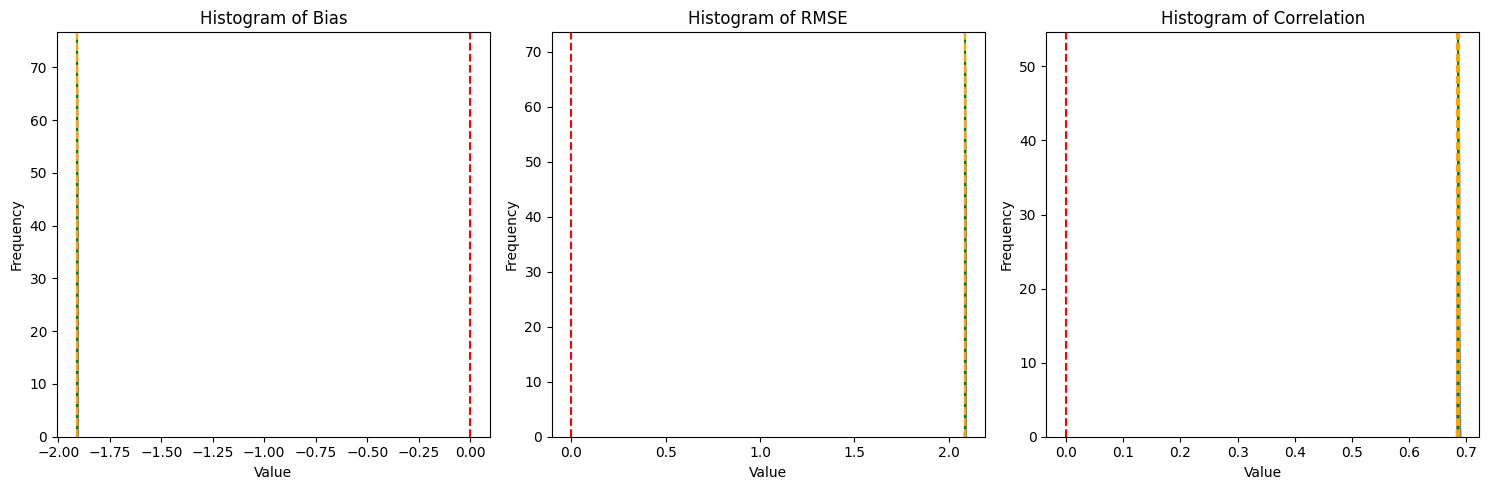

In [13]:
# plot the distributions of each error metric
import matplotlib.pyplot as plt

# Define metric names
metric_names = ['Bias', 'RMSE', 'Correlation']

# Define number of metrics to plot
n_metrics = len(metric_names)

# Adjust rows and columns calculation to avoid empty subplots
n_plots = n_metrics  # Total number of plots needed
n_rows = 1
n_cols = (n_plots + n_rows - 1) // n_rows  # Calculate columns needed, ensuring we have enough space

# Adjust the figsize if necessary
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), squeeze=False)  # Make sure axes is always a 2D array

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

for i, name in enumerate(metric_names):
    data = metrics[name]  # Access data directly from dictionary
    median_val = np.median(data)
    confidence_interval = np.percentile(data, [2.5, 97.5])
    
    ax = axes_flat[i]
    ax.hist(data, bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(x=confidence_interval[1], color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--', label='Zero line')  # Highlight 0 with a line
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Ensure plot encompasses 0 by adjusting xlim if necessary
    xlims = ax.get_xlim()
    ax.set_xlim(min(xlims[0], 0), max(xlims[1], 0))
    

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes_flat[j])

# Adjust layout for better spacing and display the plot
plt.tight_layout()
plt.show()